In [1]:
import jax
from position2 import Position2
from dataclasses import dataclass, field
import numpy as np
import matplotlib.pyplot as plt
from math import *
import scipy.interpolate
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
import functools
import jax.random
from flax.optim.adam import Adam

ROS is not sourced. To enable ROS features, please source it


In [2]:
# class TickTock(object):
#     def __init__(self):
#         self._timers = defaultdict()

# Load SLAM data

In [3]:
# datafile = "/media/mikhail/Data3T/slam_benchmark/intel.clf"
datafile = "/home/mikhail/Downloads/intel.gfs(4).log" # Corrected intel map
# datafile = "/home/mikhail/Downloads/intel.gfs.log"

In [4]:
@dataclass(frozen=True)
class LaserData(object):
    ranges: np.array
    angles: np.array
    timestamp: float
    odometry_position: Position2
        
    def as_points(self):
        mask = self.ranges < 10
        x = self.ranges[mask] * np.cos(self.angles[mask])
        y = self.ranges[mask] * np.sin(self.angles[mask])
        return np.stack([x, y], axis=1)

    def as_points_in_odometry_frame(self):
        points = self.as_points()
        return self.odometry_position.apply(points)

In [5]:
laser_data_list = []
with open(datafile, "r") as fd:
    for line in fd.readlines():
        line = line.strip()
        tokens = line.split(' ')
        if len(tokens) <= 180:
            continue
        num_scans = int(tokens[1])
        ranges = np.array([float(r) for r in tokens[2:(num_scans + 2)]])
        angles = np.linspace(-90.0 / 180.0 * np.pi, 90.0 / 180.0 * np.pi, num_scans + 1)[:-1]
        timestamp = float(tokens[(num_scans + 8)])
        odom_x, odom_y, odom_theta = [float(r) for r in tokens[(num_scans + 2):(num_scans + 5)]]
        position = Position2(odom_x, odom_y, odom_theta)
        laser_data_list.append(LaserData(ranges=ranges, angles=angles, timestamp=timestamp, odometry_position=
                                        position))

In [6]:
def show_points(laser_data_list, indeces):
    all_points = []
    for i in range(len(indeces)):
        laser_data = laser_data_list[indeces[i]]
        all_points.append(laser_data.as_points_in_odometry_frame())
    points = np.concatenate(all_points, axis=0)
    plt.scatter(points[:, 0], points[:, 1], s=0.3, c="yellow")

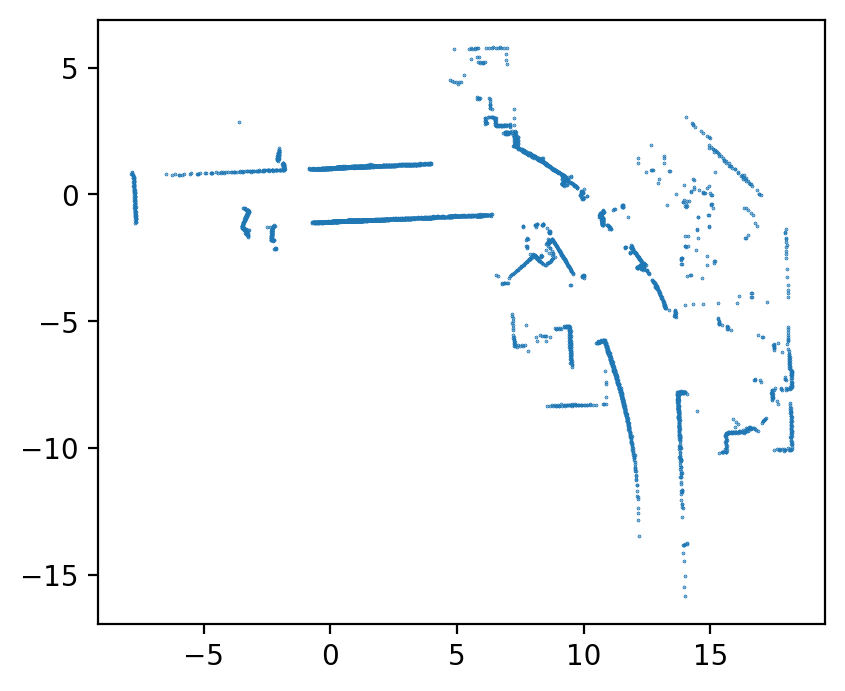

In [7]:
plt.figure(dpi=200)
all_points = []
for laser_data in laser_data_list[:30]:
    all_points.append(laser_data.as_points_in_odometry_frame())
points = np.concatenate(all_points, axis=0)
plt.scatter(points[:, 0], points[:, 1], s=0.1)
plt.gca().set_aspect('equal')

## Load ground truth

In [8]:
@dataclass
class StampedTrajectory():
    trajectory: Position2
    times: np.array
    
    def interpolate(times):
        result = scipy.interpolate.interp1d(self.times, self.trajectory, kind="linear", axis=0, 
                                            fill_value="extrapolate")(times)
        return result

# Rendering

In [9]:
class NFModel(nn.Module):
    mean: float
    sigma: float

    @nn.compact
    def __call__(self, x):
        x = (x - self.mean) / self.sigma
        x = nn.Dense(256, use_bias=True)(x)      
        x = jnp.concatenate([jnp.sin(x[:, :128]), jnp.cos(x[:, 128:])], axis=1)
        x1 = x
        x1 = nn.Dense(256)(x1)
        x1 = nn.relu(x1)
#         x1 = nn.Dense(256)(x1)
#         x1 = nn.relu(x1)
#         x1 = nn.Dense(128)(x1)
#         x1 = nn.relu(x1)
        x = jnp.concatenate([x, x1], axis=-1)
        x = nn.Dense(256)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x[:, 0]


In [12]:
def plot_model_heatmap(model, variables, bounds, vmax=None, grid_shape=(200, 200)):
    grid_x, grid_y = jnp.meshgrid(jnp.linspace(bounds[0], bounds[1], grid_shape[0]), 
                                  jnp.linspace(bounds[2], bounds[3], grid_shape[1]))
    grid = jnp.stack([grid_x, grid_y], axis=2).reshape(-1, 2)
    obstacle_probabilites = jax.nn.softplus(model.apply(variables, grid))
    obstacle_probabilites = np.array(obstacle_probabilites).reshape(*grid_shape)
    grid = grid.reshape(grid_shape[0], grid_shape[1], 2)
    plt.gca().pcolormesh(grid[:, :, 0], grid[:, :, 1], obstacle_probabilites, cmap='RdBu', shading='auto',
                        vmin=0, vmax=None)
    plt.gca().set_aspect('equal')

In [13]:
model = NFModel(0, 0.2)
batch = jnp.ones([10, 2])
variables = model.init(jax.random.PRNGKey(1), batch)
output = model.apply(variables, batch)

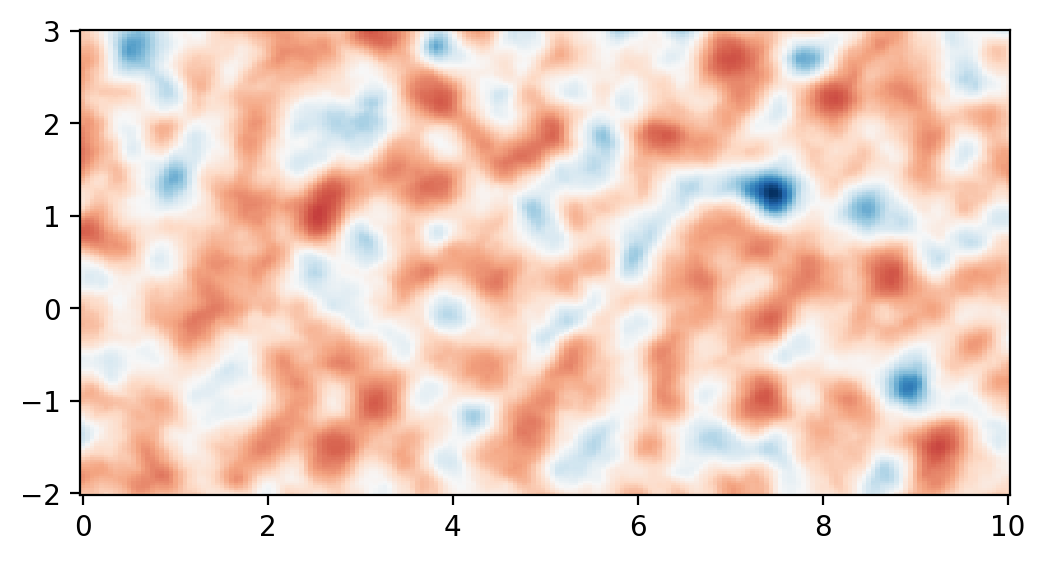

In [14]:
plt.figure(dpi=200)
plot_model_heatmap(model, variables, (0, 10, -2, 3))

In [15]:
@dataclass(unsafe_hash=True)
class ModelConfig(object):
    minimal_depth: float
    maximal_depth: float
    bins_count: int
    density_scale: float
    variance_weight: float
    depth_delta: float = field(init=False)
    def __post_init__(self):
        self.depth_delta = (self.maximal_depth - self.minimal_depth) / self.bins_count

In [16]:
@jax.jit
def calculate_weights(densities, depth_deltas):
    mis_probability = jnp.exp(-densities * depth_deltas)
    hit_probability = 1 - mis_probability
    mis_probability = jnp.concatenate([jnp.ones(1), mis_probability])
    hit_probability = jnp.concatenate([hit_probability, jnp.ones(1)])
    cumproduct = jnp.cumprod(mis_probability)
    weights = cumproduct * hit_probability
    return weights

@functools.partial(jax.jit, static_argnums=1)
def sample_depth_bins(uniform, parameters):
    depths = jnp.linspace(parameters.minimal_depth, parameters.maximal_depth, parameters.bins_count + 1)[:-1]
    depths = depths + parameters.depth_delta * uniform
    return jnp.concatenate([jnp.full([depths.shape[0], 1], parameters.minimal_depth), 
                            depths, 
                            jnp.full([depths.shape[0], 1], parameters.maximal_depth)], axis=-1)

@jax.jit
def transform_points(points, x, y, angle):
    x = x[..., None]
    y = y[..., None]
    angle = angle[..., None]
    transformed_x = x + points[..., 0] * jnp.cos(angle) - points[..., 1] * jnp.sin(angle)
    transformed_y = y + points[..., 0] * jnp.sin(angle) + points[..., 1] * jnp.cos(angle)
    return jnp.stack([transformed_x, transformed_y], axis=-1)


def calculate_points(depths, angles):
    x = depths * jnp.cos(angles[..., None])
    y = depths * jnp.sin(angles[..., None])
    return jnp.stack([x, y], axis=-1)
    
@functools.partial(jax.jit, static_argnums=7)
def loss_function(variables, truth_depths, angles, uniform, x, y, angle, config):
    depth_bins = sample_depth_bins(uniform, config)
    depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
    depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
    points = calculate_points(depths, angles)
    points = transform_points(points, x, y, angle).reshape(-1, 2)
    densities = config.density_scale * jax.nn.softplus(model.apply(variables, points)).reshape(depths.shape[:2])
    weights = jax.vmap(calculate_weights)(densities, depth_deltas)
    extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
    predicted_depths = jnp.sum(weights * extended_depths, axis=-1)
    predicted_variance = jnp.sum(weights * (extended_depths - predicted_depths[..., None]) ** 2, axis=-1)
#     return jnp.mean((truth_depths - predicted_depths) ** 2 / jax.lax.stop_gradient(predicted_variance + 1e-4))
    return jnp.mean((truth_depths - predicted_depths) ** 2 / jax.lax.stop_gradient(predicted_variance + 1e-2) +
                   config.variance_weight * predicted_variance)

## Test loss

In [17]:
config = ModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    bins_count=40,
    density_scale=0.5,
    variance_weight=0.5
)
batch = jnp.ones([10, 2])
variables = model.init(jax.random.PRNGKey(1), batch)
n = 30
loss = loss_function(variables, truth_depths=jnp.ones(n), angles=jnp.ones(n), 
     uniform=jnp.ones([n, config.bins_count]),
              x=jnp.ones(n), y=jnp.ones(n),
              angle=jnp.ones(n), config=config)
print(loss)
grad_function = jax.grad(loss_function)
grad = grad_function(variables, truth_depths=jnp.ones(n), angles=jnp.ones(n), 
     uniform=jnp.ones([n, config.bins_count]),
              x=jnp.ones(n), y=jnp.ones(n),
              angle=jnp.ones(n), config=config)

5.8578596


In [18]:
index = 6
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))
x = laser_data.odometry_position.x
y = laser_data.odometry_position.y
angle = laser_data.odometry_position.rotation
loss_function(variables, depths, angles, uniform, x, y, angle, config)

DeviceArray(6.097144, dtype=float32)

# Run on one scan

In [19]:
iterations = 100
index = 6
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))
x = laser_data.odometry_position.x
y = laser_data.odometry_position.y
angle = laser_data.odometry_position.rotation
batch = jnp.ones([10, 2])
variables = model.init(jax.random.PRNGKey(1), batch)
grad_function = jax.grad(loss_function)
optimizer = Adam(5e-3, beta1=0.9, beta2=0.999)
state = optimizer.init_state(variables)
losses = []
for i in range(iterations):
    uniform = jax.random.uniform(jax.random.PRNGKey(i), (len(depths), config.bins_count))
    grad = grad_function(variables, depths, angles, uniform, x, y, angle, config)
    loss = loss_function(variables, depths, angles, uniform, x, y, angle, config)
    losses.append(loss)
    variables, state = optimizer.apply_gradient(optimizer.hyper_params, variables, state, grad)
losses[-1]

DeviceArray(0.03275559, dtype=float32)

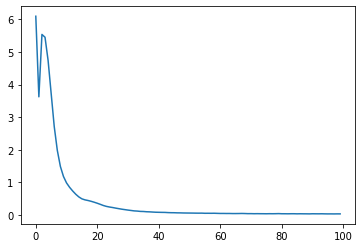

In [20]:
plt.plot(losses)

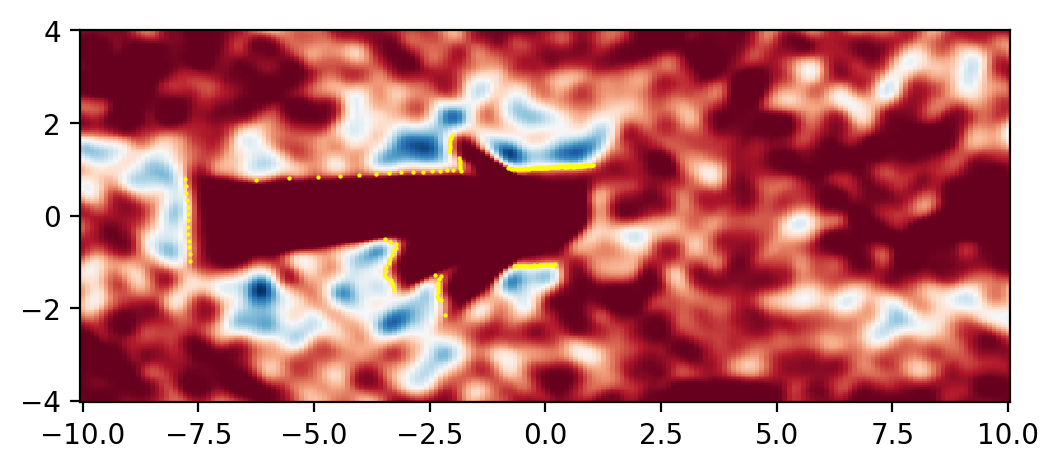

In [21]:
plt.figure(dpi=200)
plot_model_heatmap(model, variables, (-10, 10, -4, 4))
all_points = []
for laser_data in laser_data_list[index:index + 1]:
    all_points.append(laser_data.as_points_in_odometry_frame())
points = np.concatenate(all_points, axis=0)
plt.scatter(points[:, 0], points[:, 1], s=0.3, c="yellow")
plt.gca().set_aspect('equal')

0.025668824


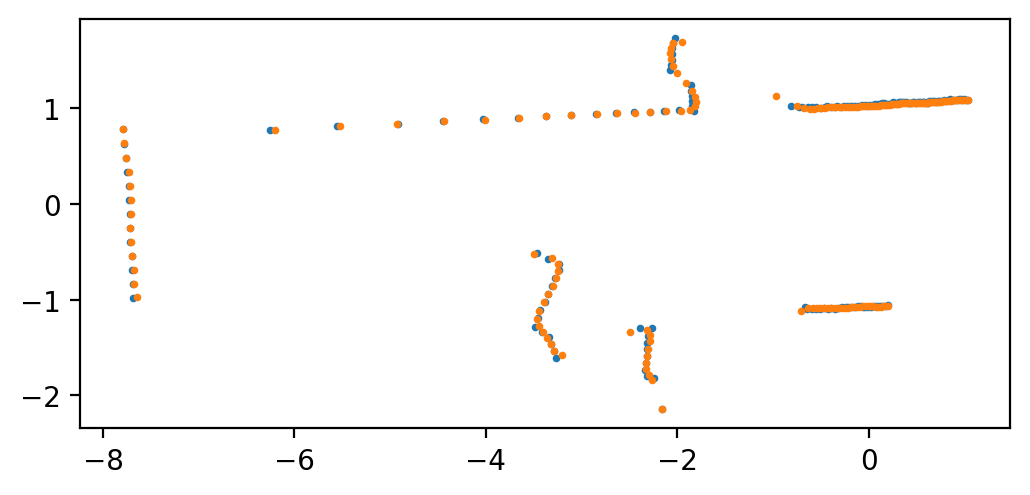

In [25]:
plt.figure(dpi=200)
index = learning_index
# index = 8
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
truth_depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
# uniform = jax.random.uniform(jax.random.PRNGKey(8), (len(depths), config.bins_count))
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
depth_bins = sample_depth_bins(uniform, config)
depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
points = calculate_points(depths, angles).reshape(-1, 2)
x = laser_data.odometry_position.x
y = laser_data.odometry_position.y
angle = laser_data.odometry_position.rotation
points = transform_points(points, x, y, angle)
densities = config.density_scale * jax.nn.softplus(model.apply(variables, points)).reshape(depths.shape[:2])
weights = jax.vmap(calculate_weights)(densities, depth_deltas)
extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
predicted_depths = jnp.sum(weights * extended_depths, axis=-1)
new_points = np.stack([np.cos(angles) * predicted_depths, np.sin(angles) * predicted_depths], axis=1)
new_points = laser_data.odometry_position.apply(new_points)
all_points = []
for laser_data in laser_data_list[index:index + 1]:
    all_points.append(laser_data.as_points_in_odometry_frame())
measurement_points = np.concatenate(all_points, axis=0)
plt.scatter(measurement_points[:, 0], measurement_points[:, 1], s=3)
plt.gca().set_aspect('equal')
plt.scatter(new_points[:, 0], new_points[:, 1], s=3)
print(jnp.sqrt(jnp.mean((predicted_depths - truth_depths) ** 2)))

## Run on several scans

In [1252]:
iterations = 20 * 7
laser_data_indeces = np.repeat(np.arange(100)[:, None], 20, axis=1).reshape(-1)
batch = jnp.ones([20, 2])
variables = model.init(jax.random.PRNGKey(1), batch)
grad_function = jax.grad(loss_function)

# optimizer = Adam(1e-2, beta1=0.9, beta2=0.8, weight_decay=0.1)
state = optimizer.init_state(variables)
optimizer = Adam(5e-3, beta1=0.9, beta2=0.8)
losses = []
for i in range(iterations):
    laser_data = laser_data_list[laser_data_indeces[i]]
    mask = laser_data.ranges < 10
    depths = jnp.array(laser_data.ranges[mask])
    angles = jnp.array(laser_data.angles[mask])
    uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))
    x = laser_data.odometry_position.x
    y = laser_data.odometry_position.y
    angle = laser_data.odometry_position.rotation
    uniform = jax.random.uniform(jax.random.PRNGKey(i), (len(depths), config.bins_count))
    grad = grad_function(variables, depths, angles, uniform, x, y, angle, config)
    loss = loss_function(variables, depths, angles, uniform, x, y, angle, config)
    losses.append(loss)
    variables, state = optimizer.apply_gradient(optimizer.hyper_params, variables, state, grad)
losses[-1]

DeviceArray(0.06044975, dtype=float32)

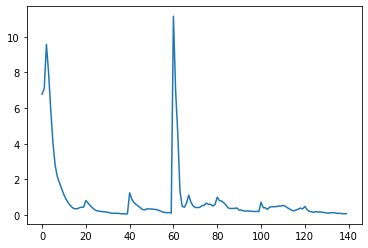

In [1095]:
plt.plot(losses)

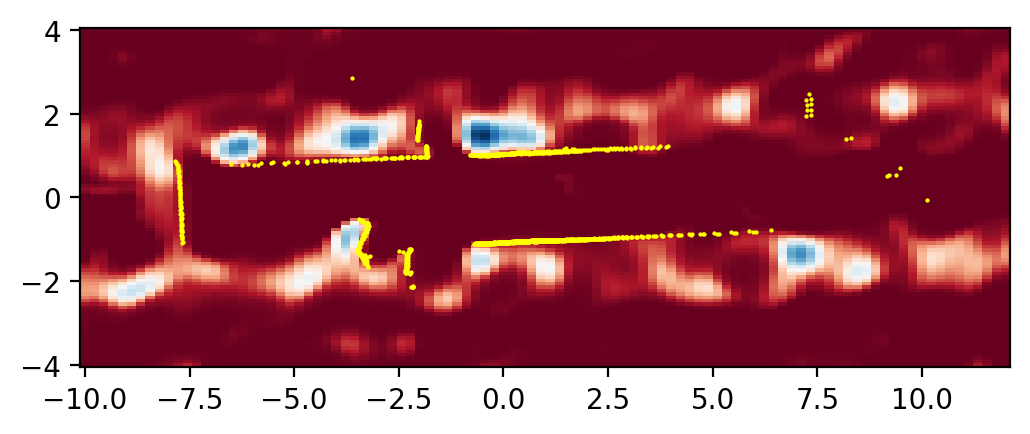

In [1096]:
plt.figure(dpi=200)
plot_model_heatmap(model, variables, (-10, 12, -4, 4))
all_points = []
for laser_data in laser_data_list[:8]:
    all_points.append(laser_data.as_points_in_odometry_frame())
points = np.concatenate(all_points, axis=0)
plt.scatter(points[:, 0], points[:, 1], s=0.3, c="yellow")
plt.gca().set_aspect('equal')

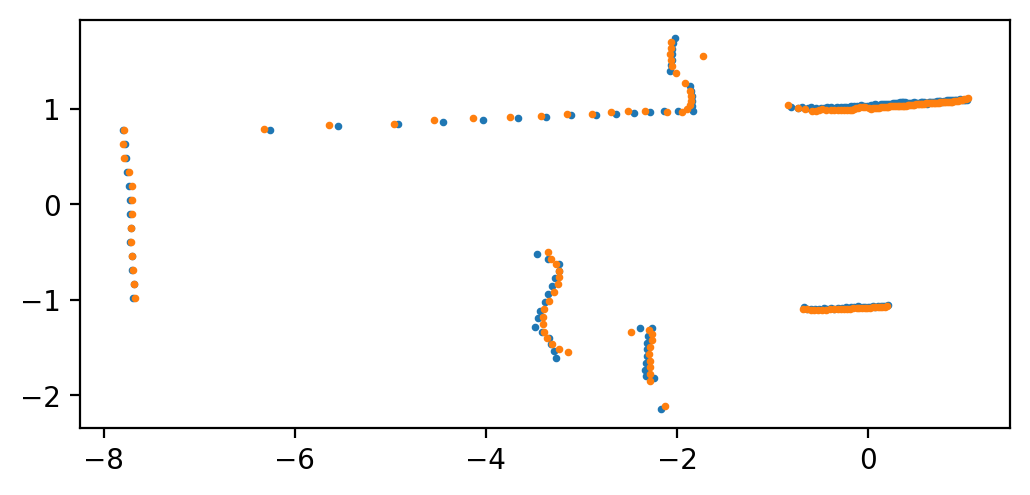

In [1097]:
plt.figure(dpi=200)
index = 6
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))
x = laser_data.odometry_position.x
y = laser_data.odometry_position.y
angle = laser_data.odometry_position.rotation
# depths = jnp.array(laser_data.ranges)
angles = jnp.array(laser_data.angles[mask])
# uniform = jax.random.uniform(jax.random.PRNGKey(2), (len(depths), config.bins_count))
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
depth_bins = sample_depth_bins(uniform, config)
depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
points = calculate_points(depths, angles).reshape(-1, 2)
points = transform_points(points, x, y, angle)
densities = config.density_scale * jax.nn.softplus(model.apply(variables, points)).reshape(depths.shape[:2])
weights = jax.vmap(calculate_weights)(densities, depth_deltas)
extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
predicted_depths = jnp.sum(weights * extended_depths, axis=-1)
new_points = np.stack([np.cos(angles) * predicted_depths, np.sin(angles) * predicted_depths], axis=1)
new_points = laser_data.odometry_position.apply(new_points)
all_points = []
for laser_data in laser_data_list[index:index + 1]:
    all_points.append(laser_data.as_points_in_odometry_frame())
measurement_points = np.concatenate(all_points, axis=0)
plt.scatter(measurement_points[:, 0], measurement_points[:, 1], s=3)
plt.gca().set_aspect('equal')
plt.scatter(new_points[:, 0], new_points[:, 1], s=3)

# Optimize on several images

In [1253]:
@dataclass
class DataPointBatch(object):
    depths: jnp.array
    angles: jnp.array
    x: jnp.array
    y: jnp.array
    angle: jnp.array

In [1254]:
def get_random_data_point_batch(laser_data_list, laser_data_indeces, scan_count, points_per_scan):
    laser_data_indeces = np.random.choice(laser_data_indeces, scan_count, replace=False)
    scan_point_indeces = np.random.choice(np.arange(180), (scan_count, point_per_scan))
    depths = []
    angles = []
    x = []
    y = []
    angle = []
    for i in range(scan_count):
        laser_data = laser_data_list[laser_data_indeces[i]]
        scan_point_index = scan_point_indeces[i]
        mask = laser_data.ranges[scan_point_index] < 10
        indeces = np.arange(mask.shape[0])[mask]
        indeces = np.random.choice(indeces, points_per_scan)
        depths.extend(list(laser_data.ranges[scan_point_index][indeces]))
        angles.extend(list(laser_data.angles[scan_point_index][indeces]))
        x.extend(list(np.full(indeces.shape[0], laser_data.odometry_position.x)))
        y.extend(list(np.full(indeces.shape[0], laser_data.odometry_position.y)))
        angle.extend(list(np.full(indeces.shape[0], laser_data.odometry_position.rotation)))
    return DataPointBatch(
        depths = jnp.array(depths),
        angles = jnp.array(angles),
        x = jnp.array(x),
        y = jnp.array(y),
        angle = jnp.array(angle)
    )

In [1255]:
def init_model_variables(model):
    batch = jnp.ones([20, 2])
    return model.init(jax.random.PRNGKey(1), batch)  

In [1260]:
config = ModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    bins_count=40,
    density_scale=0.1,
    variance_weight=0.5
)
# model = NFModel(0, 0.1)

np.random.seed(10)
iterations = 200
max_laser_data_index = 20
scan_count = 10
point_per_scan = 30
laser_data_indices = np.arange(max_laser_data_index)
variables = init_model_variables(model)
optimizer = Adam(5e-3, beta1=0.9, beta2=0.999)
# optimizer = Adam(1e-2, beta1=0.9, beta2=0.8)
state = optimizer.init_state(variables)
losses = []
for i in range(iterations):
    batch = get_random_data_point_batch(laser_data_list, laser_data_indices, 4, 50)
    uniform = jax.random.uniform(jax.random.PRNGKey(i), (batch.depths.shape[0], config.bins_count))
    grad = grad_function(variables, batch.depths, batch.angles, uniform, batch.x, batch.y, batch.angle, config)
    loss = loss_function(variables, batch.depths, batch.angles, uniform, batch.x, batch.y, batch.angle, config)
    losses.append(loss)
    variables, state = optimizer.apply_gradient(optimizer.hyper_params, variables, state, grad)
losses[-1]

DeviceArray(1.0202241, dtype=float32)

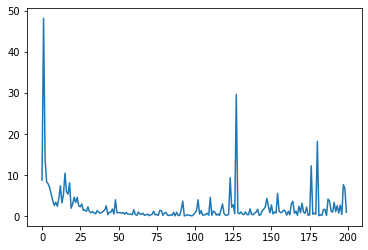

In [1261]:
plt.plot(losses)

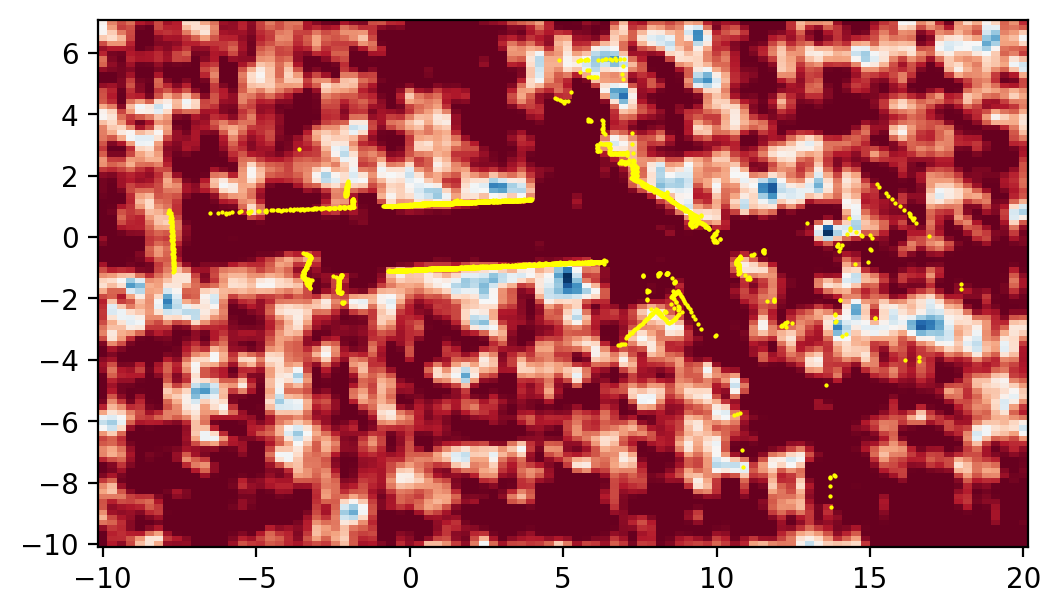

In [1262]:
plt.figure(dpi=200)
# plot_model_heatmap(model, variables, (-10, 12, -4, 4))
plot_model_heatmap(model, variables, (-10, 20, -10, 7))
show_points(laser_data_list, np.arange(20))
plt.gca().set_aspect('equal')

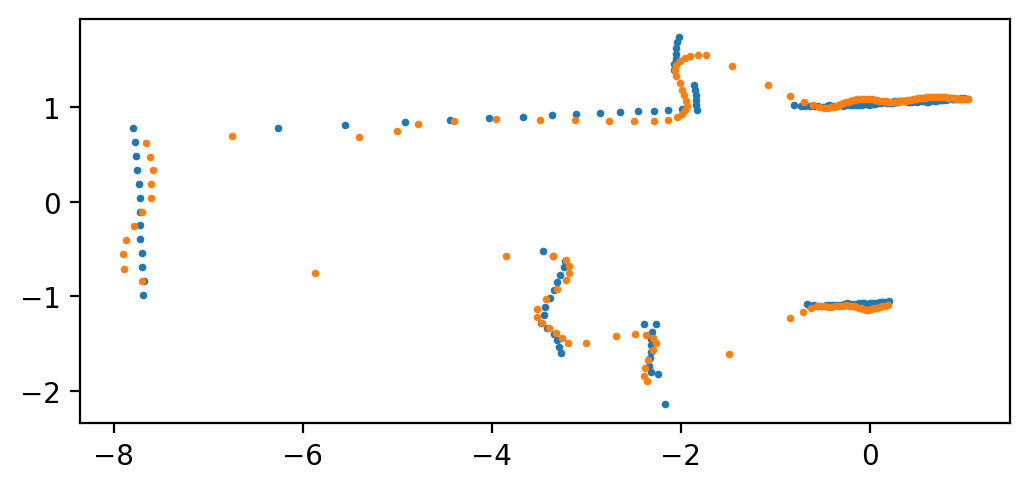

In [1264]:
plt.figure(dpi=200)
index = 6
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))
x = laser_data.odometry_position.x
y = laser_data.odometry_position.y
angle = laser_data.odometry_position.rotation
# depths = jnp.array(laser_data.ranges)
angles = jnp.array(laser_data.angles[mask])
# uniform = jax.random.uniform(jax.random.PRNGKey(2), (len(depths), config.bins_count))
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
depth_bins = sample_depth_bins(uniform, config)
depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
points = calculate_points(depths, angles).reshape(-1, 2)
points = transform_points(points, x, y, angle)
densities = config.density_scale * jax.nn.softplus(model.apply(variables, points)).reshape(depths.shape[:2])
weights = jax.vmap(calculate_weights)(densities, depth_deltas)
extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
predicted_depths = jnp.sum(weights * extended_depths, axis=-1)
new_points = np.stack([np.cos(angles) * predicted_depths, np.sin(angles) * predicted_depths], axis=1)
new_points = laser_data.odometry_position.apply(new_points)
all_points = []
for laser_data in laser_data_list[index:index + 1]:
    all_points.append(laser_data.as_points_in_odometry_frame())
measurement_points = np.concatenate(all_points, axis=0)
plt.scatter(measurement_points[:, 0], measurement_points[:, 1], s=3)
plt.gca().set_aspect('equal')
plt.scatter(new_points[:, 0], new_points[:, 1], s=3)